# Supervised Learning - Project

In this Project, we are going to perform a full unsupervised learning machine learning project on a "Wholesale Data" dataset. The dataset refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories

[Kaggle Link](https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set)

# Part I : EDA - Exploratory Data Analysis & Pre-processing

The given dataset seems to be a grocery sales dataset containing information about various products sold by a grocery store. To perform an exploratory data analysis (EDA) on this dataset, we can perform the following tasks:

- Data Import: Import the dataset into a statistical software tool such as Python or R.
- Data Cleaning: Check the dataset for any missing or incorrect data and clean the dataset accordingly. This may involve removing or imputing missing data or correcting any obvious errors.
Data Description: Generate summary statistics such as mean, median, and standard deviation for each column of the dataset. This will help in understanding the distribution of data in each column.
- Data Visualization: Create various visualizations such as histograms, box plots, scatter plots, and heatmaps to understand the relationships and trends between the different variables in the dataset. For example, we can create a scatter plot between the "Fresh" and "Milk" variables to see if there is any correlation between them.
- Outlier Detection: Check for any outliers in the dataset and determine whether they are valid or erroneous data points.
- Correlation Analysis: Calculate the correlation between different variables in the dataset to determine which variables are highly correlated and which ones are not. For example, we can calculate the correlation between "Grocery" and "Detergents_Paper" to see if there is any relationship between these two variables.
- Data Transformation: If necessary, transform the data by standardizing or normalizing the variables to make them comparable across different scales.
- Feature Selection: Identify the most important features or variables that contribute the most to the overall variance in the dataset. This can be done using various feature selection techniques such as principal component analysis (PCA) or random forest regression.

In [45]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

**Data Import:**

In [99]:
# Load and read data
df = pd.read_csv('Wholesale_Data.csv')
print(df.shape)
df.head()

(440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [101]:
# Check for NaNs
df.isnull().values.any()

False

In [100]:
# Check for duplicates
print(df[df.duplicated()])

Empty DataFrame
Columns: [Channel, Region, Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen]
Index: []


In [102]:
# See details
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


We have two channels and three regions, which Kaggle describes as the following:

    channel-1 = Ho/Re/Ca (i.e. hotel/restaurant/cafe)
    channel-2 = Retail (nominal)
    region-1 = Lisnon
    region-2 = Oporto
    region-3 = Other (nominal)

Restated here for the sake of summary, the numerical columns list annual spending in monetary units (m.u.). There are clear outliers in each of these columns, but I want to get a sense of the number and distribution of outliers before deciding how to deal with them.

I also decided to check to see if there's a substantial difference between channels or regions.

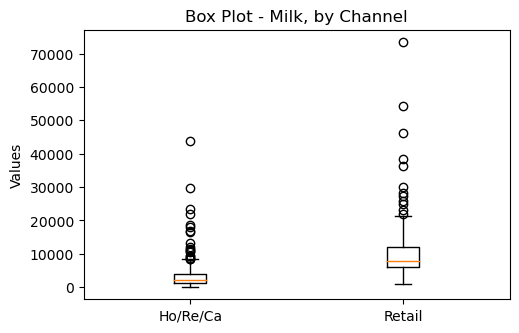

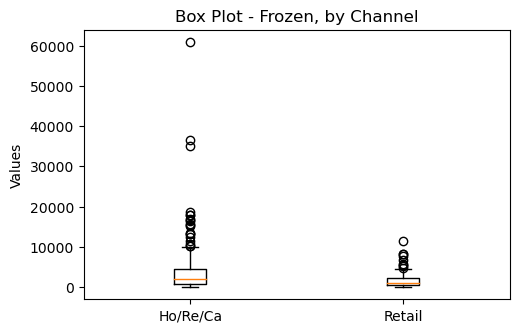

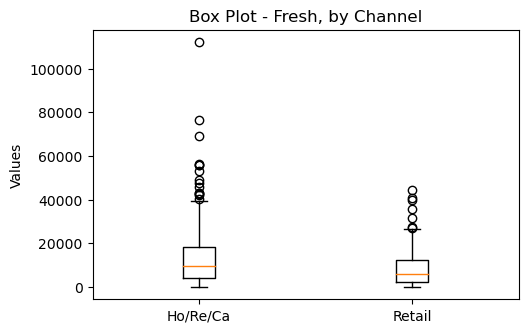

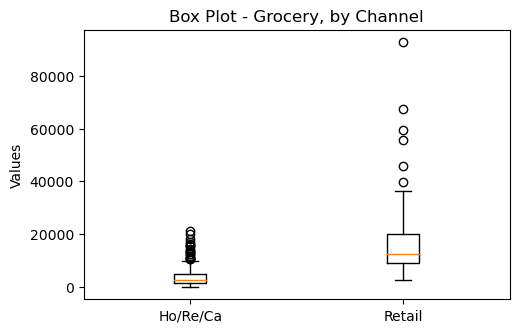

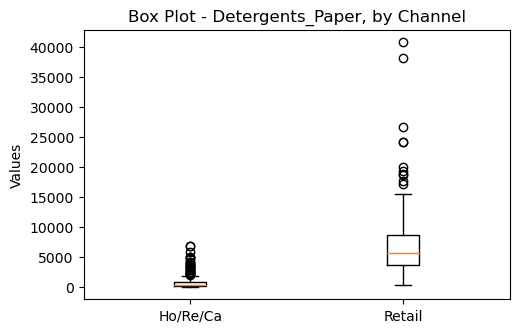

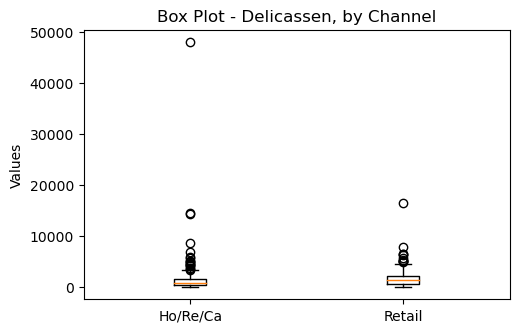

In [5]:
# List of column names for box plots
columns = ['Milk', 'Frozen', 'Fresh', 'Grocery', 'Detergents_Paper', 'Delicassen']

# Create a box plot for each channel+column pair
for column in columns:
    channel_1 = df[df['Channel'] == 1][column]
    channel_2 = df[df['Channel'] == 2][column]

    # Create two box plots
    plt.figure(figsize=(5.5, 3.5))
    plt.boxplot([channel_1, channel_2], labels=['Ho/Re/Ca', 'Retail'])
    plt.ylabel('Values')
    plt.title(f'Box Plot - {column}, by Channel')
    plt.show()

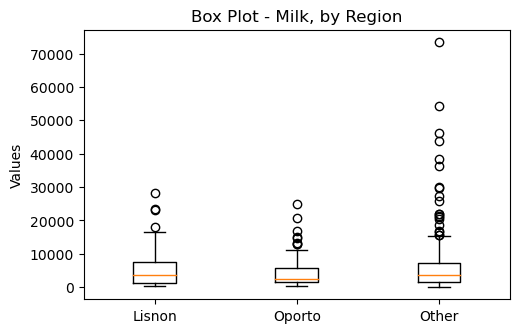

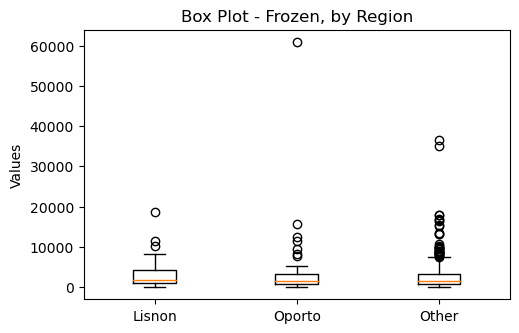

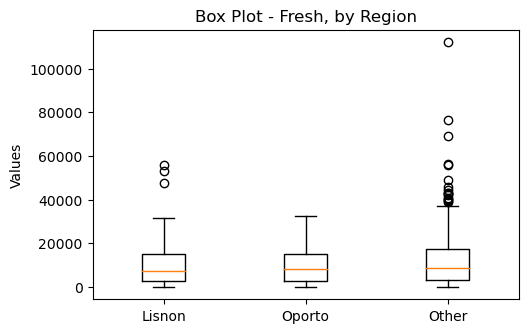

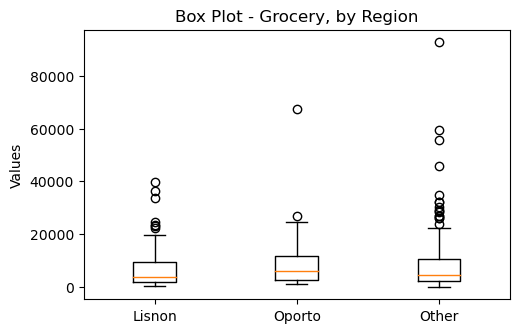

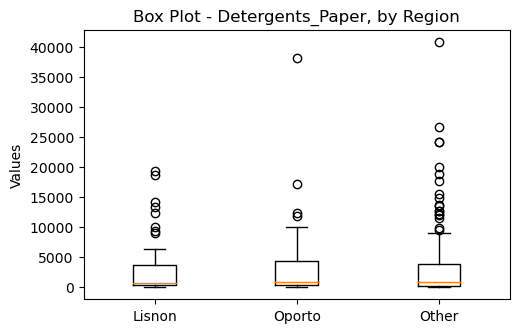

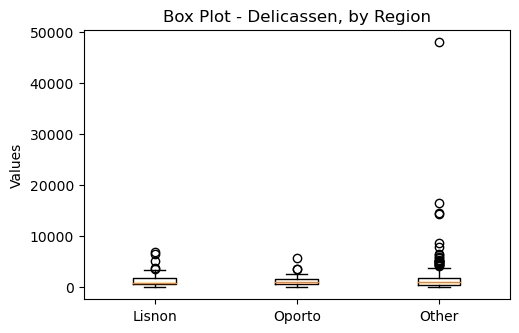

In [6]:
# List of column names for box plots
columns = ['Milk', 'Frozen', 'Fresh', 'Grocery', 'Detergents_Paper', 'Delicassen']

# Create a box plot for each region+column pair
for column in columns:
    region_1 = df[df['Region'] == 1][column]
    region_2 = df[df['Region'] == 2][column]
    region_3 = df[df['Region'] == 3][column]

    # Create a box plot
    plt.figure(figsize=(5.5, 3.5))
    plt.boxplot([region_1, region_2, region_3], labels=['Lisnon', 'Oporto', 'Other'])
    plt.ylabel('Values')
    plt.title(f'Box Plot - {column}, by Region')
    plt.show()

**Findings:** There are no substantial differences in counts or amount ranges between regions, but there are for channels (e.g. grocery sales are much greater in retail than in hotels, restaurants, or cafes). This means I should probably differentiate between the two channels when dealing with outliers and the like.

**Data Cleaning & Outlier Detection:**

For this project, I decided to employ two different strategies to deal with outliers.

1. The most extreme outliers (e.g. the record of nearly 50,000 Delicassen sales that has a large distance from the next closest record) will be dropped.
2. Several others will be replaced with median values.

Other outliers, such as those that are well within the realm of being reasonable, will remain.

While I decided to simply replace all outliers with median values in the supervised learning project, I wanted to experiment with this strategy to see if there is a noticeable effect on my end model. Channel is not considered for extreme outliers, but it is for median imputation.

In [7]:
# Calculate z-scores for columns A and B
z_scores = np.abs((df - df.mean()) / df.std())
z_scores.describe()

# Set a threshold for z-scores to define "extreme" outliers
threshold = 4

# Filter the DataFrame to drop rows with extreme outliers and copy DF for smooth code execution
df2 = df[(z_scores < threshold).all(axis=1)].copy()
print(f"DF Shape: {df.shape}")
print(f"DF2 Shape: {df2.shape}")

DF Shape: (440, 8)
DF2 Shape: (425, 8)


Only 15 rows got dropped, which is 3.4% of the total sample size; I can live with this.

In [8]:
# Define columns to deal with "moderate" outliers
columns = ['Milk', 'Frozen', 'Fresh', 'Grocery', 'Detergents_Paper', 'Delicassen']

# Loop through each column
for column in columns:
    # Calculate the median value separately for each Channel group
    median_0 = df2.loc[df2['Channel'] == 1, column].median()
    median_1 = df2.loc[df2['Channel'] == 2, column].median()
    
    # Calculate the interquartile range (IQR) separately for each Channel group
    Q1_0 = df2.loc[df2['Channel'] == 1, column].quantile(0.25)
    Q3_0 = df2.loc[df2['Channel'] == 1, column].quantile(0.75)
    IQR_0 = Q3_0 - Q1_0
    
    Q1_1 = df2.loc[df2['Channel'] == 2, column].quantile(0.25)
    Q3_1 = df2.loc[df2['Channel'] == 2, column].quantile(0.75)
    IQR_1 = Q3_1 - Q1_1
    
    # Define the lower and upper bounds for outliers separately for each Channel group
    lower_bound_0 = Q1_0 - 1.5 * IQR_0
    upper_bound_0 = Q3_0 + 1.5 * IQR_0
    
    lower_bound_1 = Q1_1 - 1.5 * IQR_1
    upper_bound_1 = Q3_1 + 1.5 * IQR_1
    
    # Replace the outliers with the median value separately for each Channel group
    df2.loc[(df2['Channel'] == 1) & ((df2[column] < lower_bound_0) | (df2[column] > upper_bound_0)), column] = median_0
    df2.loc[(df2['Channel'] == 2) & ((df2[column] < lower_bound_1) | (df2[column] > upper_bound_1)), column] = median_1

New details:

In [9]:
df2.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,1.317647,2.531765,9641.115294,4243.472941,6537.134118,2069.525882,2124.428235,1047.715294
std,0.466110,0.782806,8088.249768,3554.882164,6491.025955,2017.681655,3029.679931,814.841770
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3087.000000,1492.000000,2128.000000,720.000000,256.000000,404.000000
50%,1.000000,3.000000,7842.000000,3195.000000,3838.000000,1388.000000,573.000000,806.000000
75%,2.000000,3.000000,13970.000000,6250.000000,8852.000000,2616.000000,3321.000000,1468.000000
max,2.000000,3.000000,37036.000000,16729.000000,33586.000000,9584.000000,14235.000000,4430.000000


Now for visualisations:

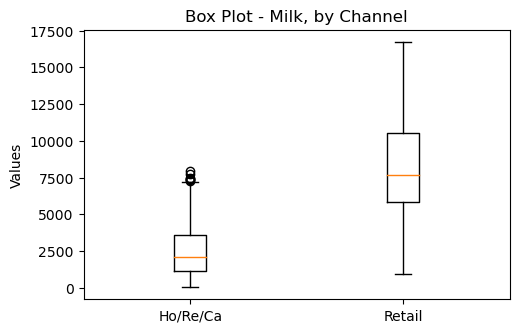

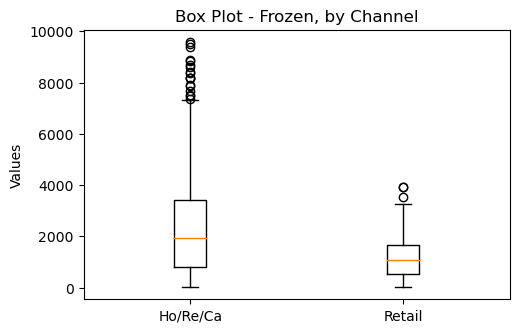

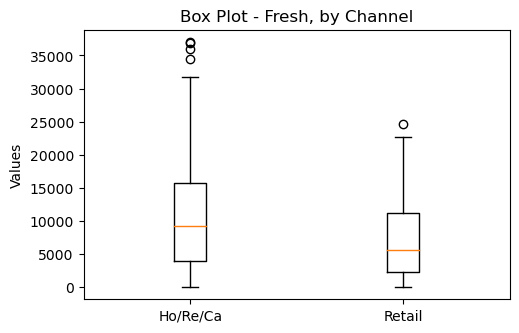

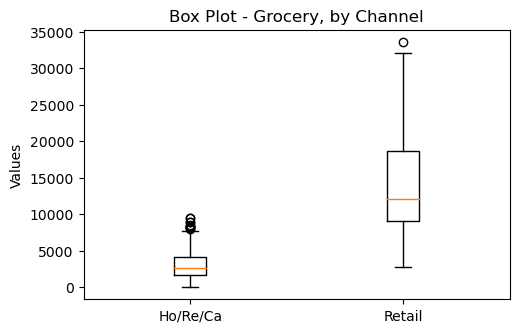

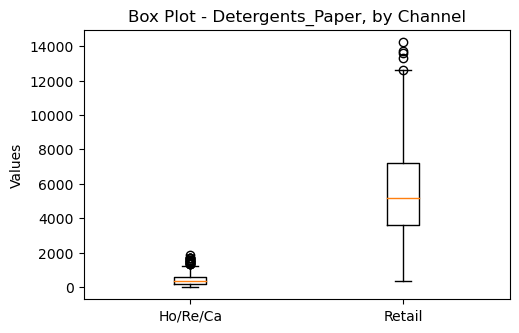

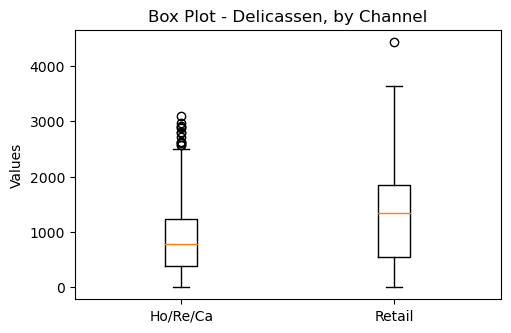

In [10]:
# List of column names for box plots
columns = ['Milk', 'Frozen', 'Fresh', 'Grocery', 'Detergents_Paper', 'Delicassen']

# Create a box plot for each channel+column pair
for column in columns:
    channel_1 = df2[df2['Channel'] == 1][column]
    channel_2 = df2[df2['Channel'] == 2][column]

    # Create two box plots
    plt.figure(figsize=(5.5, 3.5))
    plt.boxplot([channel_1, channel_2], labels=['Ho/Re/Ca', 'Retail'])
    plt.ylabel('Values')
    plt.title(f'Box Plot - {column}, by Channel')
    plt.show()

**Correlation Analysis:**

Next up, I want to do some correlation analysis and determine which product sales seem to correlate with each and which ones, if any, are largely unrelated.

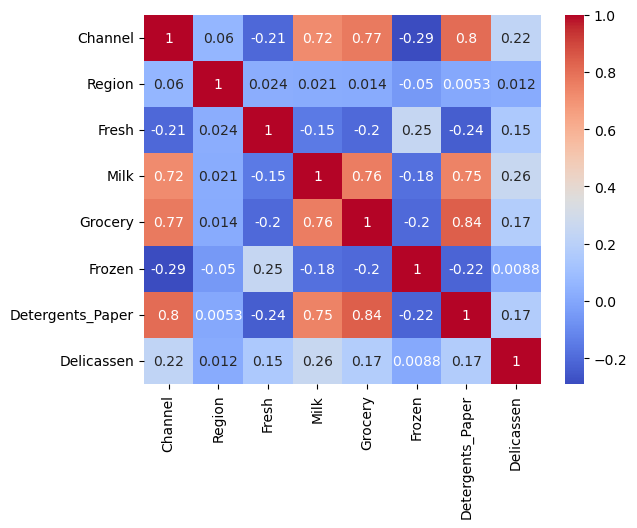

In [11]:
# Full correlation heatmap
df2_corr = df2.corr()
sns.heatmap(df2_corr, annot=True, cmap='coolwarm')
plt.show()

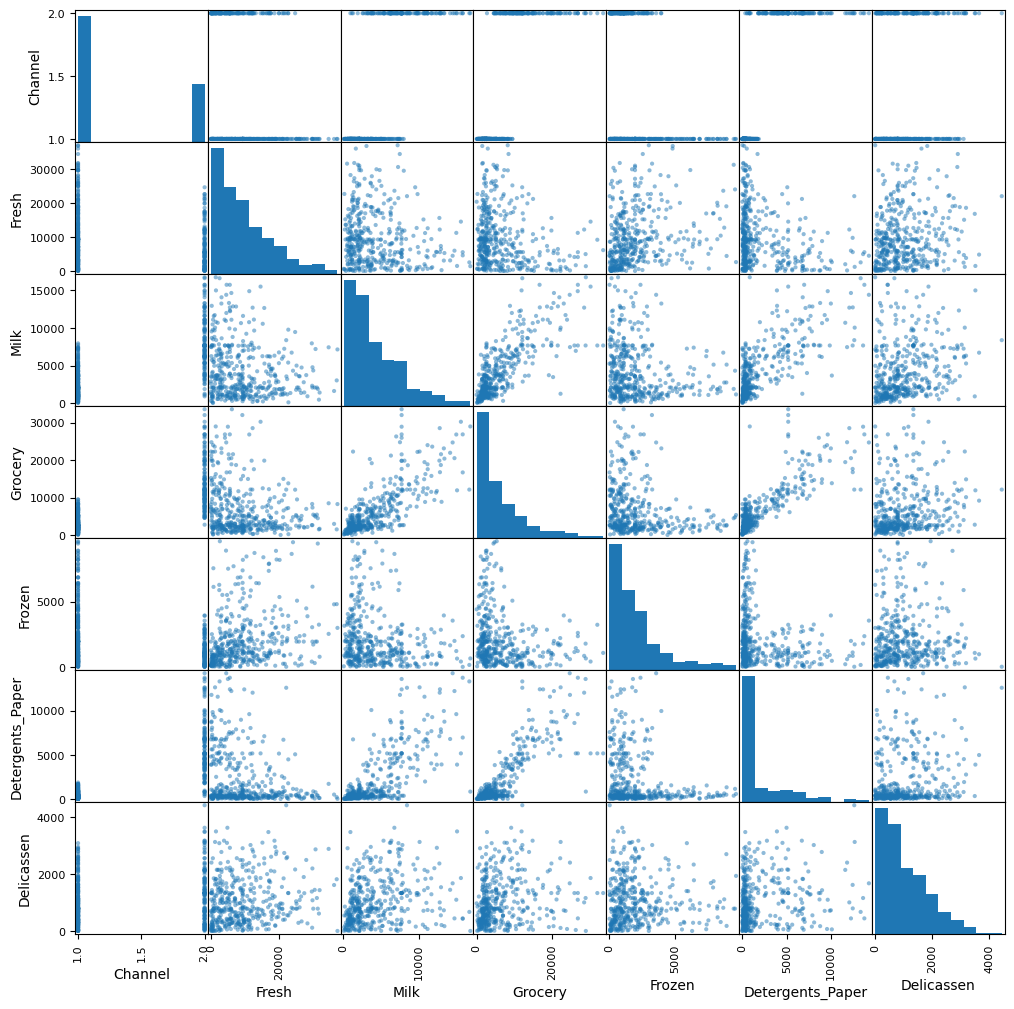

In [12]:
# Create scatter plot matrix
pd.plotting.scatter_matrix(df2[['Channel', 'Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']], figsize=(12, 12))
plt.show()

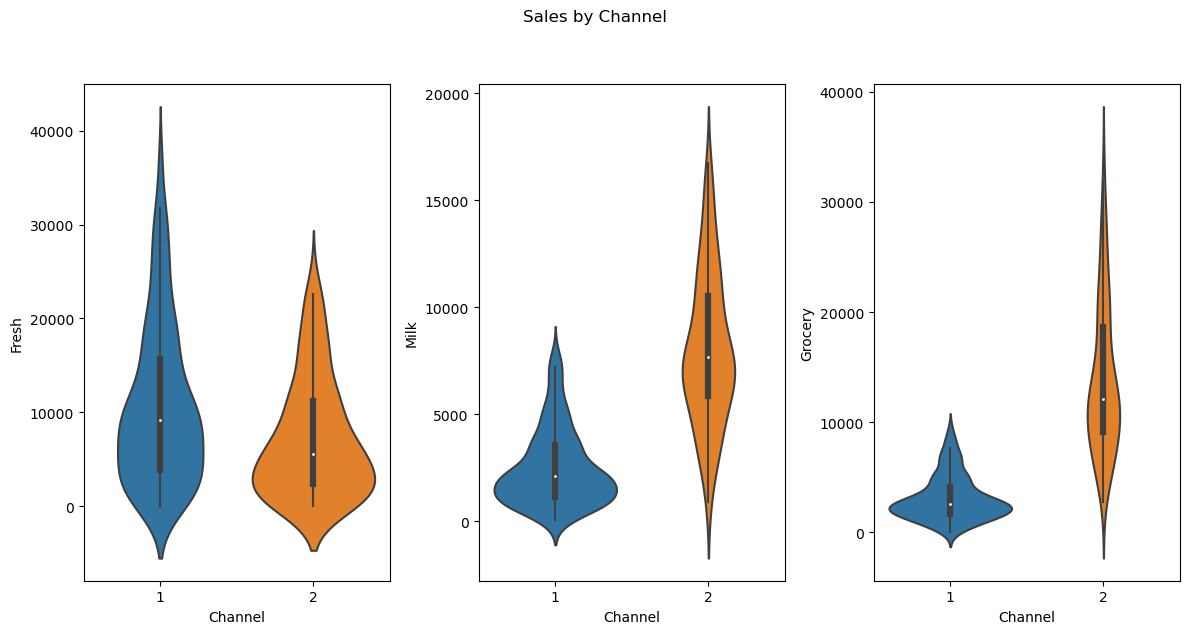

In [13]:
# Violin Columns 1
columns = ['Fresh', 'Milk', 'Grocery']

# Create pairs of violin plots
plt.figure(figsize=(12, 6))
for column in columns:
    plt.subplot(1, len(columns), columns.index(column) + 1)
    sns.violinplot(x='Channel', y=column, data=df2)
    plt.xlabel('Channel')
    plt.ylabel(column)
plt.suptitle('Sales by Channel', y=1.05)
plt.tight_layout()
plt.show()

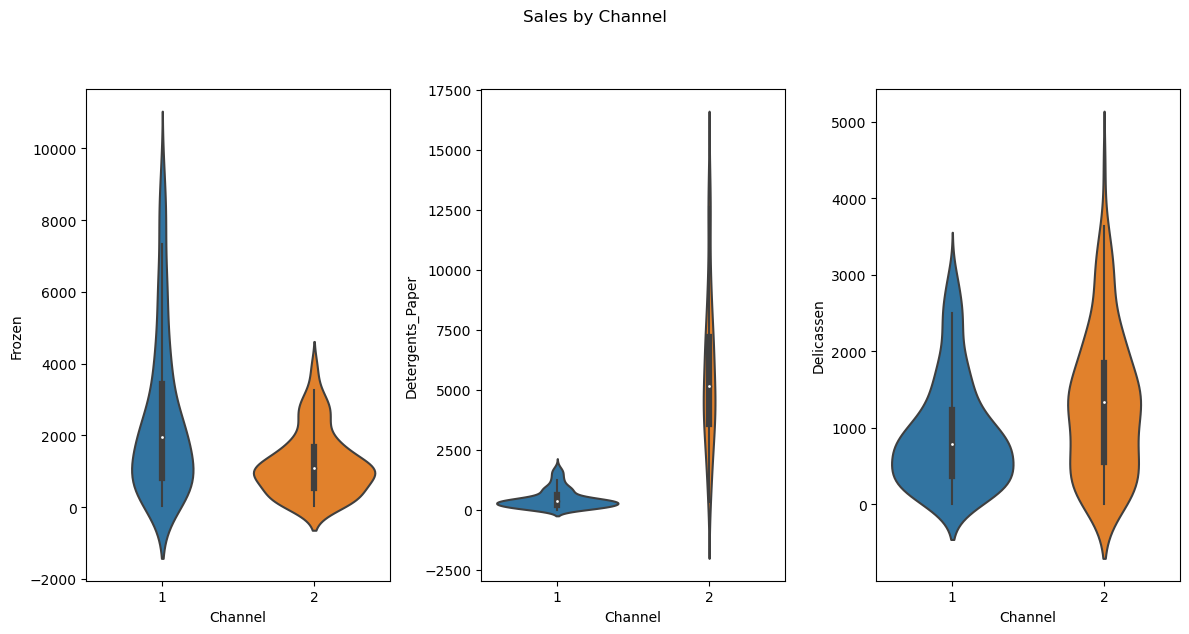

In [14]:
# Violin columns 2
columns = ['Frozen', 'Detergents_Paper', 'Delicassen']

# Create pairs of violin plots
plt.figure(figsize=(12, 6))
for column in columns:
    plt.subplot(1, len(columns), columns.index(column) + 1)
    sns.violinplot(x='Channel', y=column, data=df2)
    plt.xlabel('Channel')
    plt.ylabel(column)
plt.suptitle('Sales by Channel', y=1.05)
plt.tight_layout()
plt.show()

**Observations:** Region does not have any strong correlations with any category of product, nor does it correlate with Channel. This, paired with the visualisations generated before, suggests that trends are consistent across regions.

On the other hand, Channel has strong correlations with most categories. It should be noted that Channel has not yet been split into dummy values (same goes for Region), but if it's a scale of 1 or 2 then observations can still be summarised as the following:

Categorical Correlations: 
1. Strong positive: Milk & Grocery
2. Strong positive: Milk & Detergents_Paper

Channel Differences:
1. Fresh: Ho/Re/Ca spends more; the correlation is mild.
2. Milk: Retail spends more; the correlation is third strongest here.
3. Grocery: Retail spends more; the correlation is second strongest here.
4. Frozen: Ho/Re/Ca spends more; the correlation is mild.
5. Detergents_Paper: Retail spends more; the correlation is strongest here.
6. Delicassen: Ho/Re/Ca spends more; the correlation is mild.


**Data Transformations:**

To sum up, I want to scale the numerical values, and have decided to demonstrate hot-encoding on the region column column even if my models don't actually use these values; there is little correlation between regions and other variables, and even in running through an earlier iteration of my PCA model with them I found that they made up a negligible of the dataset's total variance. Still, it can be useful to keep them around for other analyses.

Scaling has been done later on a per-model basis so that I can keep my original data values, but the categorical transformations are done here.

Notes:
- Channel values are already set up like dummy variables, I just want to change the digits from 1 & 2 to 0 & 1.
- Region has three categories, so I'll want to properly hot-encode that.

In [15]:
# Channel value standardization
df3 = df2.copy()
df3.loc[df2['Channel'] == 1, 'Channel'] = 0
df3.loc[df2['Channel'] == 2, 'Channel'] = 1

# Dummy vars
region_encoded = pd.get_dummies(df3['Region'], prefix='Region')

# Drop original region column and copy DF for smooth code execution
df3 = df3.drop('Region', axis=1)
df3.head()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1,12669,9656,7561.0,214.0,2674,1338
1,1,7057,9810,9568.0,1762.0,3293,1776
2,1,6353,8808,7684.0,2405.0,3516,1338
3,0,13265,1196,4221.0,6404.0,507,1788
4,1,22615,5410,7198.0,3915.0,1777,1338


In [16]:
# Combine tables and display details
channel_df = df3['Channel'].copy()
df3 = df3.drop('Channel', axis=1)

# Extract numeric feature names, minus Outcomes which happens to be the last list element
num_feats = df3.dtypes[df3.dtypes != 'object'].index.tolist()
print(num_feats)

['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


In [17]:
# Reassign column names
df3.columns = num_feats

# Combine tables
df3 = pd.concat([df3.reset_index(drop=True), channel_df.reset_index(drop=True), region_encoded.reset_index(drop=True)], axis=1)

In [18]:
# Quick look
df3.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel,Region_1,Region_2,Region_3
0,12669,9656,7561.0,214.0,2674,1338,1,0,0,1
1,7057,9810,9568.0,1762.0,3293,1776,1,0,0,1
2,6353,8808,7684.0,2405.0,3516,1338,1,0,0,1
3,13265,1196,4221.0,6404.0,507,1788,0,0,0,1
4,22615,5410,7198.0,3915.0,1777,1338,1,0,0,1


**Final Check - Sample Sizes:**

My approach for the supervised learning project was to simply change my model's threshold to weigh the smaller sample more. However, since we are not supervising these models, we can be content with simply knowing for our own knowledge how the final sample sizes differ from one another.

In [19]:
print(f"Channel Counts: \n{df3['Channel'].value_counts().sort_index()}")

Channel Counts: 
0    290
1    135
Name: Channel, dtype: int64


As we can see here, it is imbalanced; Channel 1 has more than twice the number of Channel 2 records. This means that Retail businesses will be less represented in the modelling, although hopefully this also means they will be easier to identify.

# Part II - KMeans Clustering

The objective of the analysis is to group similar products together into clusters based on their attributes such as fresh, milk, grocery, frozen, detergents_paper, and delicatessen. To perform the k-means clustering analysis, you will need to pre-process the dataset, determine the optimal number of clusters, initialize the centroids, assign data points to clusters, update the centroids, and repeat until convergence.

Fitting data: While I initially scaled my data earlier, I decided to just repeat it every time I fit a model.

In [20]:
# Extract the first six columns for clustering
X = df3.iloc[:, :6].values

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

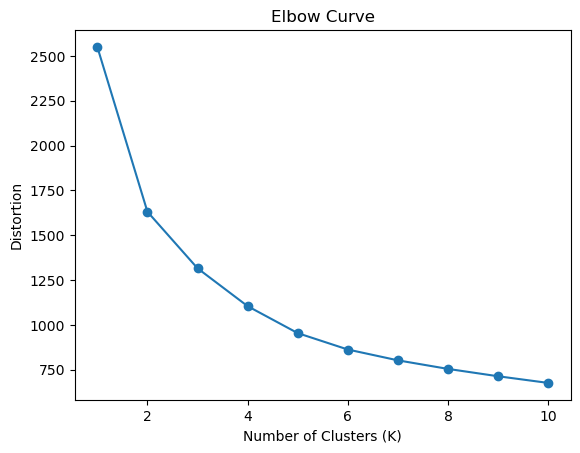

In [21]:
# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.title('Elbow Curve')
plt.show()

Distortion drops get consistent around 6 clusters, but the last sizeable shift happens when going into 4 clusters so that the number of clusters I will assume exist here.

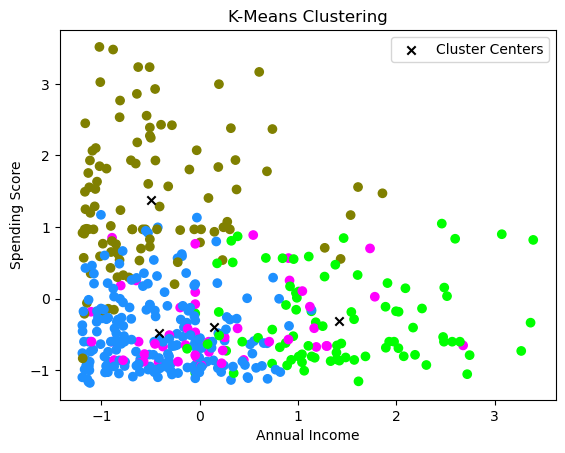

In [22]:
# Set the optimal number of clusters
n_clusters = 4

# Fit K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
kmeans.fit(X_scaled)
y_km = kmeans.predict(X_scaled)

# Define custom colors for each cluster
colors = ['olive', 'dodgerblue', 'magenta', 'lime', 'aqua', 'orange']

# Plot the clusters with custom colors
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=[colors[label] for label in kmeans.labels_], cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='black', label='Cluster Centers')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('K-Means Clustering')
plt.legend()
plt.show()

They are not the easiest to see, but we can identify the areas where different datapoints tend to cluster. Trying a different visualisation:

In [80]:
 def plot_clusters(X,y_res, plt_cluster_centers):
    X_centroids = []
    Y_centroids = []
    
    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))
        
        plt.scatter(x,
                    y,
                    s=30,
                    marker='s',
                    label=f'cluster {cluster}')
        
    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='black',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

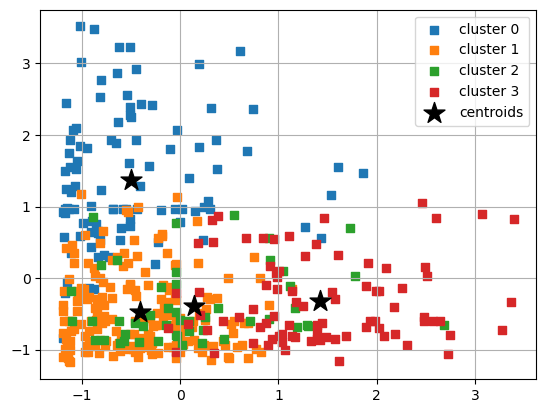

In [81]:
# Plot clustering result
plot_clusters(X, y_km, plt_cluster_centers=True)

# Part III - Hierarchical Clustering 

Hierarchical clustering is a popular unsupervised machine learning algorithm that is used to identify patterns and group similar data points together in a hierarchy. The algorithm works by iteratively merging or splitting clusters based on a similarity measure until a dendrogram is formed.

To perform hierarchical clustering analysis, you will need to pre-process the dataset, determine the optimal number of clusters using techniques such as dendrogram.

In [25]:
# Extract the first six columns
X = df3.iloc[:, :6].values

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create an object
ac = AgglomerativeClustering(metric='euclidean',
                             linkage='ward',
                             n_clusters = 2)

# Model
y_hc = ac.fit_predict(X_scaled)

In [26]:
# define plot_dendrogram function
def plot_dendrogram(X,method ='ward'):
    dendrogram = sch.dendrogram(sch.linkage(X, method=method))
    plt.title("Dendrogram")
    plt.ylabel("Euclidean distances")
    plt.xlabel('Points')
    plt.show()

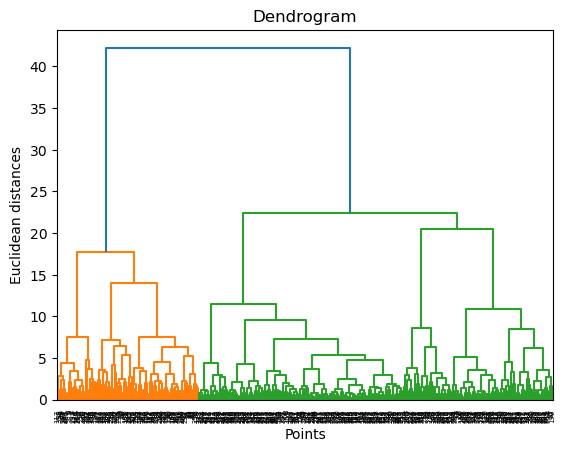

In [27]:
plot_dendrogram(X_scaled)

This model identifies only two clear clusters with scaled data, yet three with unscaled data.

In [78]:
def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []
    
    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))
        
        plt.scatter(x,
                    y,
                    s=30,
                    marker='s',
                    label=f'cluster {cluster}')
        
    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

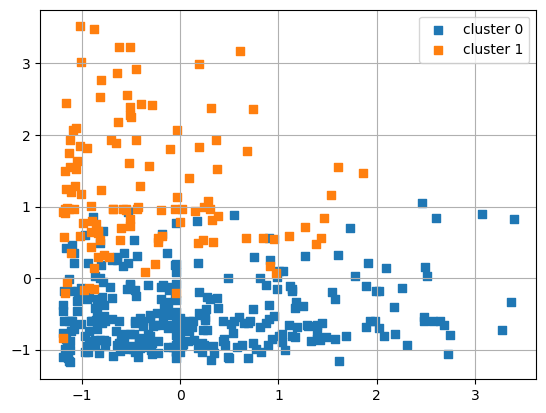

In [79]:
# Plot for 3 clusters (unscaled)
plot_clusters(X_scaled,y_hc)

# Part IV - PCA

In this section you are going to perform principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

In [82]:
# Keep hot-encoded regions for analysis
df_set = df3.drop(['Region_1', 'Region_2', 'Region_3'], axis=1)

# X and y
X = df_set.drop(['Channel'],axis=1)
y = df_set['Channel']

# Scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Isolate columns into new DF
dfx = pd.DataFrame(data=X,columns=df_set.columns[:6])
dfx.head(10)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.374797,1.524356,0.157922,-0.920716,0.181610,0.356667
1,-0.319867,1.567728,0.467482,-0.152595,0.386163,0.894828
2,-0.407009,1.285530,0.176893,0.166463,0.459854,0.356667
3,0.448571,-0.858274,-0.357241,2.150777,-0.534490,0.909572
4,1.605932,0.328535,0.101932,0.915729,-0.114810,0.356667
5,-0.028237,1.130912,-0.217654,-0.696433,-0.108862,0.495507
6,0.307584,-0.294160,0.067537,-0.788727,0.335603,-0.617675
7,-0.255252,0.200672,0.445580,-0.198742,0.395415,1.865484
8,-0.455284,-0.167706,-0.053234,-0.816018,-0.134968,-0.365796
9,-0.449961,1.929065,1.903923,-0.451805,1.751610,1.290462


In [83]:
# Model
pca = PCA(n_components=None)
dfx_pca = pca.fit(dfx)

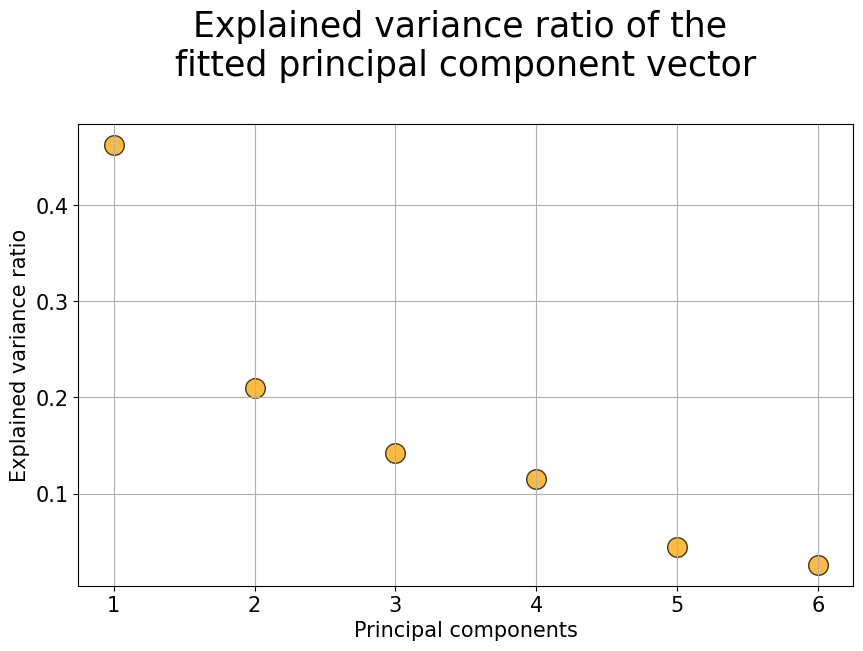

In [85]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],
            y=dfx_pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [86]:
pca.explained_variance_ratio_

array([0.46301857, 0.20933478, 0.14238868, 0.11502875, 0.04428969,
       0.02593953])

Quick Summary: The first principal component contains about 46.3% of the explained variance, while the second principle component contains 20.9% (running total: 67.2%), the third 14.2% (81.4%), and the fourth 11.5% (92.9%). While the remaining two components make up less than 10% of the total variance, it is arguable that the fourth component is not super relevant for our purposes given that over 80% of the total variance can be explained by the first three components.

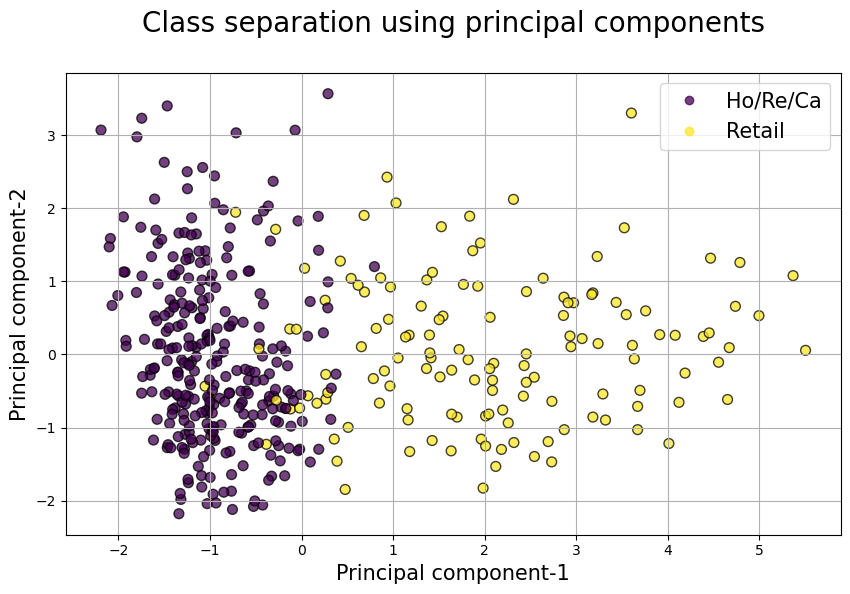

In [90]:
dfx_trans = pca.transform(dfx)
dfx_trans = pd.DataFrame(data=dfx_trans)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(dfx_trans[0], dfx_trans[1], c=df3['Channel'], edgecolors='k', alpha=0.75, s=50)
plt.grid(True)
plt.title("Class separation using principal components\n", fontsize=20)
plt.xlabel("Principal component-1", fontsize=15)
plt.ylabel("Principal component-2", fontsize=15)
targets = ['Ho/Re/Ca', 'Retail']
plt.legend(handles=scatter.legend_elements()[0], labels=targets, prop={'size': 15})
plt.show()


Both channels are substantially different from each other when comparing these two principal components, having only a little overlap approaching PC-1 = 0. 

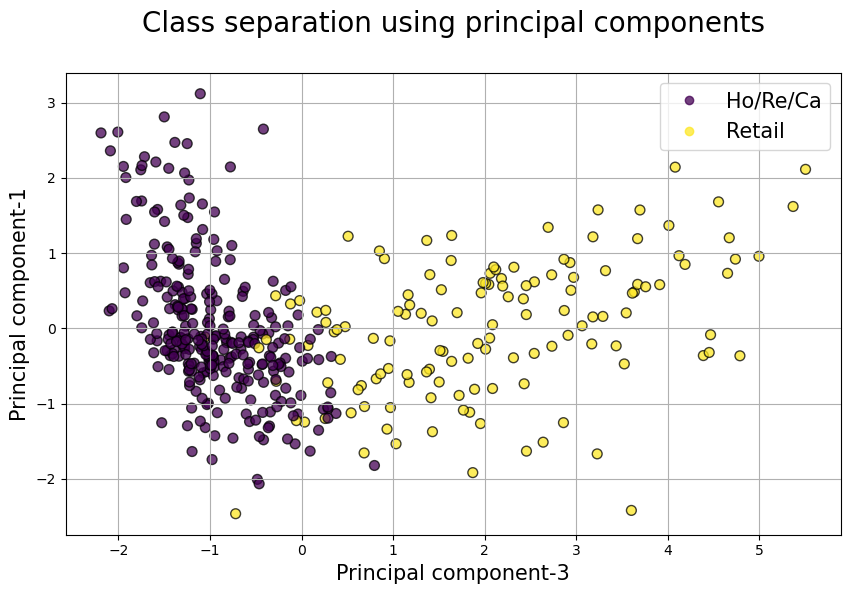

In [94]:
dfx_trans = pca.transform(dfx)
dfx_trans = pd.DataFrame(data=dfx_trans)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(dfx_trans[0], dfx_trans[2], c=df3['Channel'], edgecolors='k', alpha=0.75, s=50)
plt.grid(True)
plt.title("Class separation using principal components\n", fontsize=20)
plt.xlabel("Principal component-3", fontsize=15)
plt.ylabel("Principal component-1", fontsize=15)
targets = ['Ho/Re/Ca', 'Retail']
plt.legend(handles=scatter.legend_elements()[0], labels=targets, prop={'size': 15})
plt.show()


There is a pretty clear distinction between both channels here; Retails is largely PC-3 positive while Ho/Re/Ca is largely PC-1 negative. They also diverge further the greater PC-1 gets, on average. 

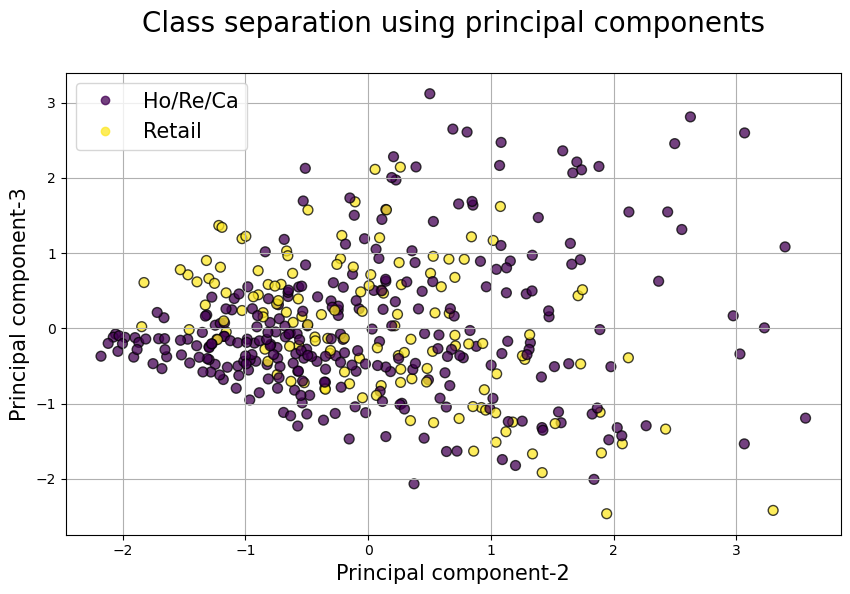

In [96]:
dfx_trans = pca.transform(dfx)
dfx_trans = pd.DataFrame(data=dfx_trans)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(dfx_trans[1], dfx_trans[2], c=df3['Channel'], edgecolors='k', alpha=0.75, s=50)
plt.grid(True)
plt.title("Class separation using principal components\n", fontsize=20)
plt.xlabel("Principal component-2", fontsize=15)
plt.ylabel("Principal component-3", fontsize=15)
targets = ['Ho/Re/Ca', 'Retail']
plt.legend(handles=scatter.legend_elements()[0], labels=targets, prop={'size': 15})
plt.show()


Even though it is the third highest principle component, we can see that there is not much variance between our two Channels (Ho/Re/Ca and Retail) when it comes to our third principal component; the clearest distinction can be made in the lower portions of PC-2, with Ho/Re/Ca having a clear origin point in the negatives of PC-3 and Retail having a clear origin point in the positives of PC-3. However, both spread outward quite a bit from that point and the distinction diminishes.

# Part V - Conclusion

From the model you developed and the exploratory data analysis (EDA) conducted, generate four bullet points as your findings.

While working with the Wholesale Data dataset, I was able to analyse and model the data to work out the following:
- Correlations:
    - Businesses who buy detergents & paper products also tend to buy a lot of grocery and milk products. 
    - Similarly, there is a mild correlation between fresh and frozen food sales, as well as delicatessen and milk sales. 
    - We have a mild negative correlation between fresh and detergents/paper products, which suggests that clients are less likely to buy both together. There are similarly mild negative correlations for frozen products to grocery products, and for frozen to detergents & paper.

- There are no substantial differences in the purchasing habits of wholesale customers between different regions, meaning that any strategies employed to improve sales should be applicable in any of the three identified regions or region categories.
- Depending on the clustering method used, we can identify 2-4 distinct business clusters from the data. This could allow, for example, marketing or sales strategies to maximize the employer's business operations.
- There are some areas where our two Channels, Ho/Re/Ca and Retail, differ substantially in terms of their buying habits and what they need to conduct business. This could be used to conduct further analyses to figure out exactly how to proceed, but these variances exist and are important to note.